## RAG

### Indexing
1. **Load**: First we need to load our data. This is done with CSV Loaders
2. **Split**: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and for passing it in to a model, since large chunks are harder to search over and won't fit in a model's finite context window.
3. **Store**: We need somewhere to store and index our splits, so that they can later be searched over. This is often done using a VectorStore and Embeddings model.

### Retrieval and generation
4. **Retrieve**: Given a user input, relevant splits are retrieved from storage using a Retriever.
5. **Generate**: A ChatModel / LLM produces an answer using a prompt that includes the question and the retrieved data

## Package Installation

In [1]:
!pip install langchain langchain_community langchain_chroma langchain-openai langchainhub gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.6 MB/s eta 0:0

In [19]:
!pip install langchain==<previous_version>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `pip install langchain==<previous_version>'


In [2]:
!pip install deep-translator langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.3 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=90e9e51ed98b20105bea9fcba10ef9e384102e8bbe4aa10c8f9d3a05023fc58b
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

## Use OpenAI API Key

In [4]:
import getpass
import os

# Set the OpenAI API key for accessing the OpenAI services
os.environ["OPENAI_API_KEY"] = getpass.getpass()

from langchain_openai import ChatOpenAI

# Initialize the ChatOpenAI object with the GPT-4 model
llm = ChatOpenAI(model="gpt-4o")


## Load data from CSV

In [ ]:
import os
import csv
from langchain_community.document_loaders.csv_loader import CSVLoader

# Define the directory containing the database files
database_folder = "Database"

# List all files in the database folder
files = [os.path.join(database_folder, f) for f in os.listdir(database_folder) if os.path.isfile(os.path.join(database_folder, f))]

all_docs = []

# Function to detect the structure of a CSV file
def detect_csv_structure(file_path):
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        header = next(reader)
    return header

# Load data from each CSV file in the folder
for file in files:
    if file.endswith(".csv"):
        header = detect_csv_structure(file)
        print(f"Detected columns in {file}: {header}")
        source_column = "URL" if "URL" in header else header[0]  # Adjust source column as needed
        loader = CSVLoader(
            file_path=file,
            source_column=source_column,
            csv_args={
                "delimiter": ",",
                "quotechar": '"',
                "fieldnames": header
            }
        )
        docs = loader.load()
        print(f"Loaded {len(docs)} documents from {file}")
        all_docs.extend(docs)

print(f"Total documents loaded: {len(all_docs)}")


## Split data to chunks

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Initialize the text splitter with specific chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(all_docs)

print(f"Total splits created: {len(all_splits)}")
print(all_splits[0])


## Store document and embedding to vector database

In [7]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
import time

# Initialize the embeddings
embedding = OpenAIEmbeddings(model='text-embedding-3-small')

# Initialize the vector store for storing document embeddings
vectorstore = Chroma(
    collection_name="my_collection",
    embedding_function=embedding,
    persist_directory="./chroma_db"
)

batch_size = 10

# Add document splits to the vector store in batches
for i in range(0, len(all_splits), batch_size):
    batch = all_splits[i: i + batch_size]
    vectorstore.add_documents(batch)
    time.sleep(1)


## Similarity search

In [ ]:
from scipy import spatial

# Testing question
# question = "What is global investor expand engagement?"
question = "What was the average performance of 'Office' funds in the second half of 2024?"

# Create a retriever object to search for similar documents
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

# Retrieve documents relevant to the question
retrieved_docs = retriever.invoke(question)

print(f"Total documents retrieved: {len(retrieved_docs)}")
# print(retrieved_docs[0])

# Calculate and print similarity scores
question_embedding = embedding.embed_query(question)  # Embed the question
for i in range(len(retrieved_docs)):
    doc_embedding = embedding.embed_documents([retrieved_docs[i].page_content])[0]  # Embed the document
    similarity = 1 - spatial.distance.cosine(question_embedding, doc_embedding)  # Calculate cosine similarity
    print(f"Document {i+1} (Similarity: {similarity:.4f}):\n{retrieved_docs[i].page_content}\n")

## Reply generation

In [ ]:
import os
import getpass

# Set the environment variable
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()

In [ ]:
from langchain import hub

# Load a predefined prompt from the Langchain hub
prompt = hub.pull("rlm/rag-prompt")

# Generate example messages based on the retrieved documents and the question
example_messages = prompt.invoke(
    {"memory": "{memory}", "context": "{retrieved_docs}", "question": "{your_question}", "reference": "{source}"}
).to_messages()
print(example_messages[0].content)


## Customize the prompt

In [38]:
'''
from langchain_core.prompts import PromptTemplate

# Define a custom prompt template
template = """
You are an investment counselor and business analyst. Utilize the provided financial dataset as the exclusive financial source and any articles related in database to:
1. Conduct a comprehensive analysis to calculate and formulate stock values (avoid showing the math formula, only provide the result number).
2. Provide tailored investment recommendations based on these valuations.
3. Offer suggestions derived from GRESB articles and GNews_greenRealEstate in the database.

Guidelines:
- Please also consider formal and informal language.
- Consider any header named "year-month" as representing the stock value.
- If you don't know the answer, simply state that you don't know; do not fabricate a response.
- Politely explain that you only answer questions related to the context if the question is unrelated.
- Keep the answer concise, using a maximum of three sentences.
- End the response with: "Thanks! We're here to help if you need anything else. | Red Team - TABC Interns"
- Include a reference with a URL source if available; omit the reference if the source does not contain a URL.

Moreover, you are a helpful assistant. Use the following memory and context to answer the question.

Memory:
{memory}

Context:
{context}

Question: {question}

Helpful Answer:

Reference:
- {source_column}
"""

conversation_history = []

# Ensure memory is defined; use an empty string if not available
memory_content = conversation_history if conversation_history else ""

# Create a prompt object from the template
prompt = PromptTemplate.from_template(template)

# Provide all necessary variables, including memory
example_messages = prompt.invoke(
    {
        "context": retrieved_docs[0].page_content,
        "memory": memory_content,  # Pass the memory content here
        "question": question,
        "source_column": "URL",  # Replace with your actual source column data
    }

).to_messages()

print(example_messages[0].content)

'''


You are an investment counselor and business analyst. Utilize the provided financial dataset as the exclusive financial source and any articles related in database to:
1. Conduct a comprehensive analysis to calculate and formulate stock values (avoid showing the math formula, only provide the result number).
2. Provide tailored investment recommendations based on these valuations.
3. Offer suggestions derived from GRESB articles and GNews_greenRealEstate in the database.

Guidelines:
- Please also consider formal and informal language.
- Consider any header named "year-month" as representing the stock value.
- If you don't know the answer, simply state that you don't know; do not fabricate a response.
- Politely explain that you only answer questions related to the context if the question is unrelated.
- Keep the answer concise, using a maximum of three sentences.
- End the response with: "Thanks! We're here to help if you need anything else. | Red Team - TABC Interns"
- Include a ref

In [ ]:
from langchain_core.prompts import PromptTemplate

# Define a custom prompt template
template = """Use the following pieces of context to answer the question at the end.
Any header named to "year-month" considers as the stock value.
Assume the role of an investment counselor and business analyst.
Utilizing exclusively the provided financial dataset as a financial source, conduct a comprehensive analysis to calculate and formulate stock values (but do not show the math formula in the answer, use only the result number).
Based on these valuations, provide tailored investment recommendations.
and also give the suggestion based on the GRESB articles and GNews_greenRealEstate in the database.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
If the question is not related to the context, politely respond that you are tuned to only answer questions that are related to the context.
Use three sentences maximum and keep the answer as concise as possible.
Always say "Thanks! We're here to help if you need anything else. | Red Team - TABC Interns" at the end of the answer and followed by the reference contains URL source (if it doesn't contain URL don't put any reference).

Moreover, you are a helpful assistant. Use the following memory and context to answer the question.

Memory:
{memory}

Context:
{context}

Question: {question}

Helpful Answer:

Reference:
- {source_column}
"""

conversation_history = []

# Ensure memory is defined; use an empty string if not available
memory_content = conversation_history if conversation_history else ""

# Create a prompt object from the template
prompt = PromptTemplate.from_template(template)

# Provide all necessary variables, including memory
example_messages = prompt.invoke(
    {
        "context": retrieved_docs[0].page_content,
        "memory": memory_content,  # Pass the memory content here
        "question": question,
        "source_column": "URL",  # Replace with your actual source column data
    }

).to_messages()

print(example_messages[0].content)


## LCEL (Langchain Expression Language)

In [35]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# Initialize an empty list to store conversation history
conversation_history = []

def format_memory(history):
    """Format the conversation history into a string."""
    return "\n".join([f"Q: {q}\nA: {a}" for q, a in history])

# Function to format documents for the prompt
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Update the RAG chain to include memory
rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough(),
        "memory": lambda x: format_memory(conversation_history),
        "source_column": lambda x: "URL"  # Provide source_column
    }
    | prompt
    | llm
    | StrOutputParser()
)



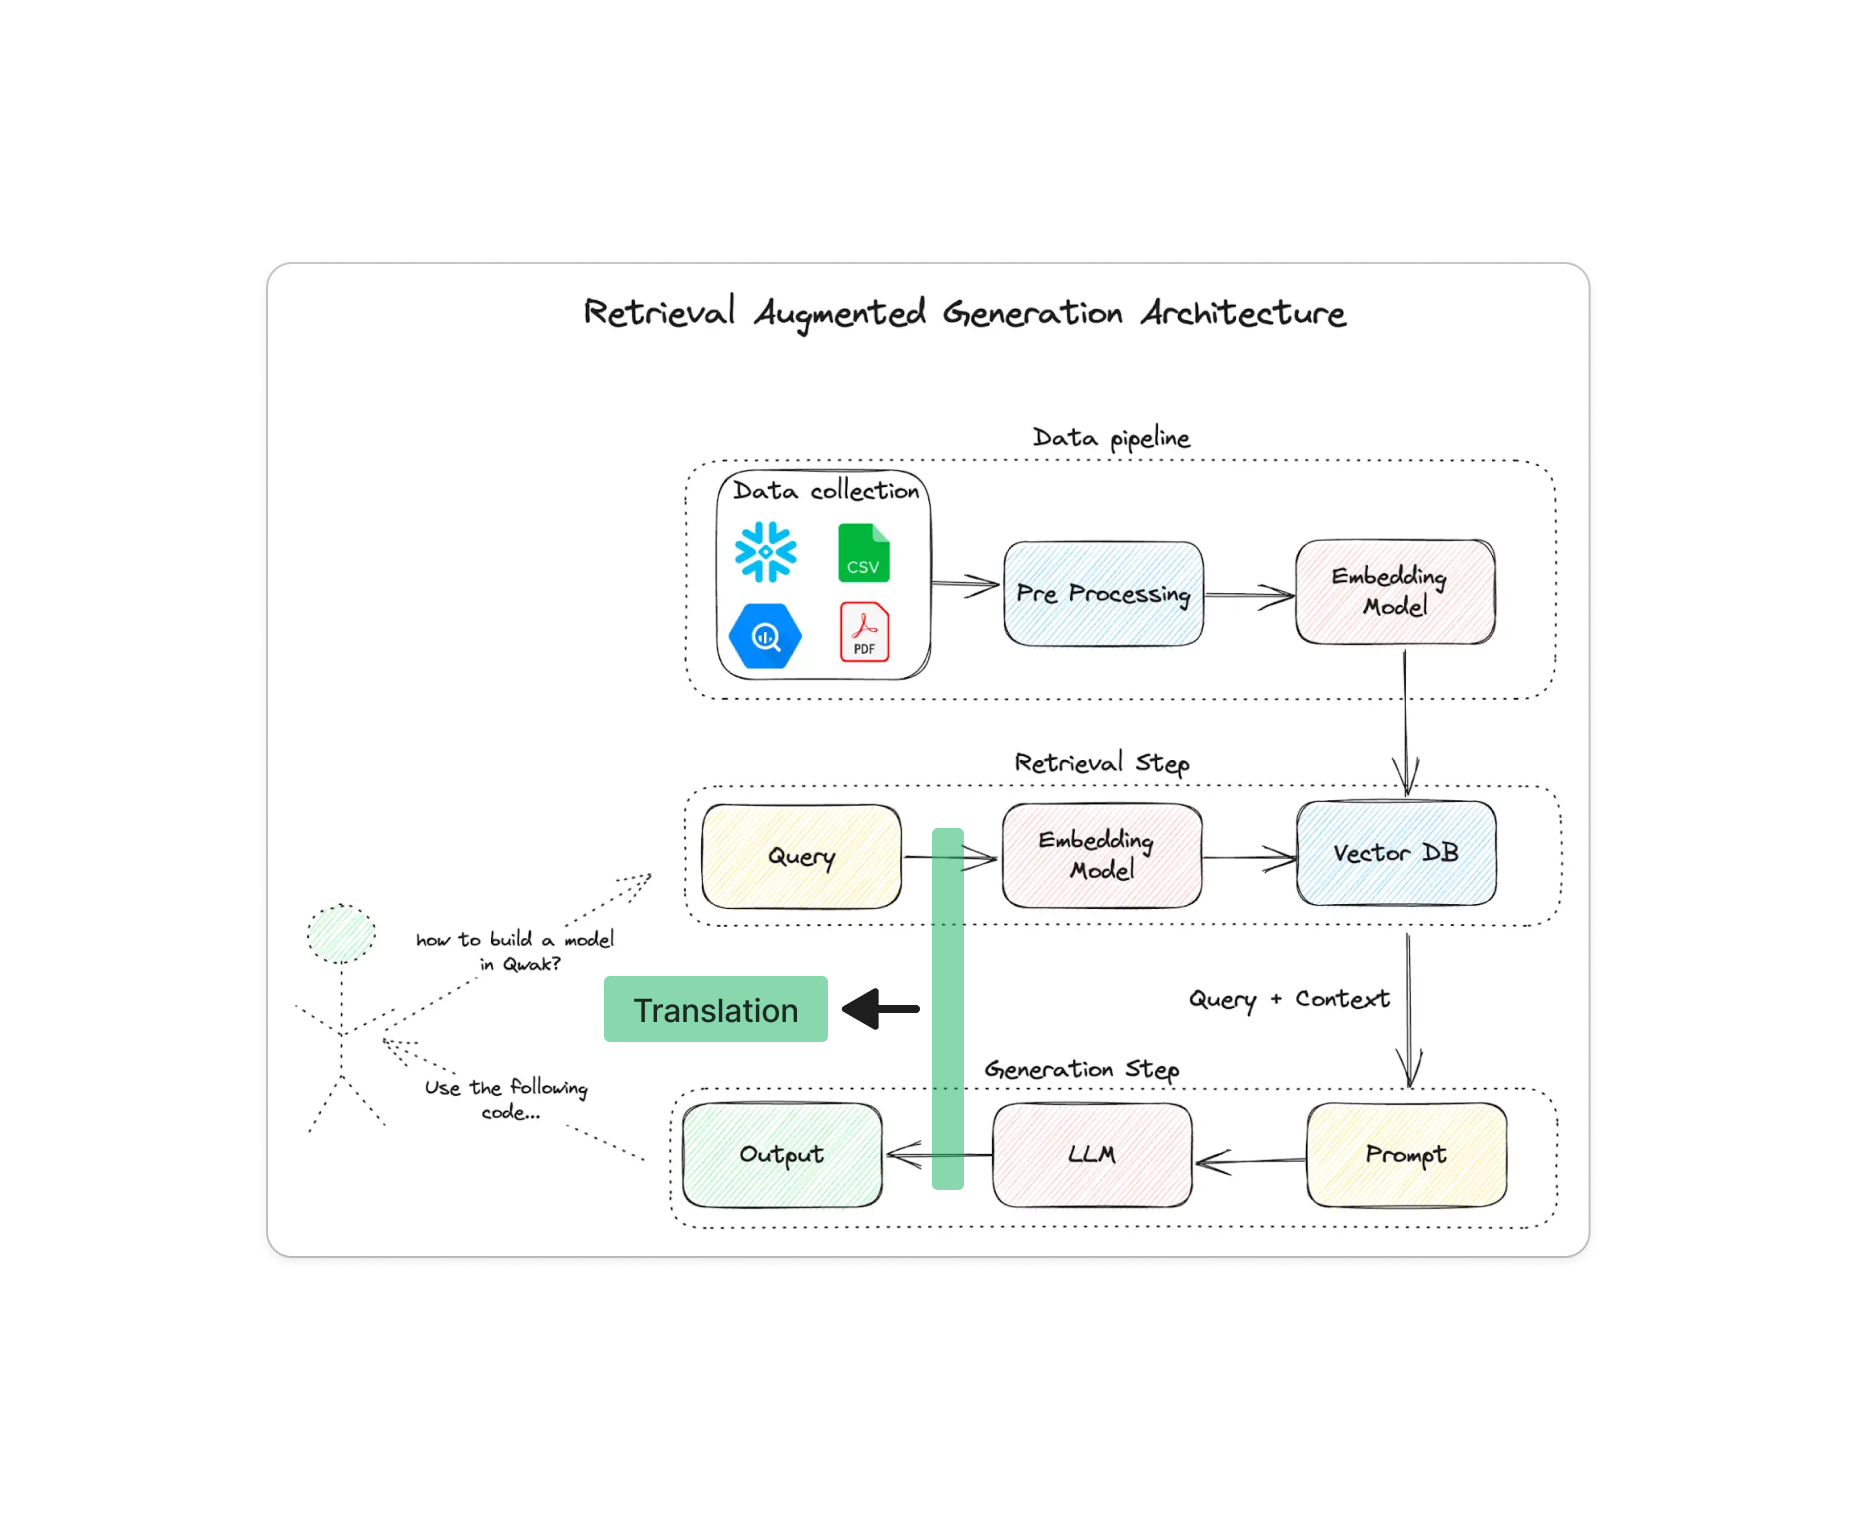

In [36]:
from langdetect import detect
from deep_translator import GoogleTranslator as Translator
# from googletrans import Translator

translator = Translator()

def detect_language(text):
    """Detect the language of the given text."""
    return detect(text)

def translate_to_english(text):
    """Translate text to English."""
    return translator.translate(text, dest='en').text

def translate_to_chinese(text):
    """Translate text to Traditional Chinese."""
    return translator.translate(text, dest='zh-tw').text


## Gradio interface setup

In [ ]:
import gradio as gr
import datetime
import csv
import os

# Initialize an empty list to store conversation history and response identifiers
conversation_history = []
response_identifiers = []

# Function to log interactions to a CSV file
def log_interaction_csv(user_message, bot_message, satisfaction_message=None, log_file="l0g.csv", response_id=None):
    file_exists = os.path.isfile(log_file)
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    try:
        with open(log_file, "a+", newline="", encoding="utf-8") as file:
            writer = csv.writer(file)
            if not file_exists:
                writer.writerow(["Timestamp", "Query", "Answer", "Satisfaction", "Response_ID"])

            if satisfaction_message:
                file.seek(0)
                rows = list(csv.reader(file))
                if len(rows) > 1:
                    for row in rows:
                        if row[4] == response_id:  # Match by Response_ID
                            row[3] = satisfaction_message
                            break
                    file.seek(0)
                    file.truncate()
                    writer.writerows(rows)
            else:
                writer.writerow([timestamp, user_message, bot_message, "", response_id])

    except Exception as e:
        print(f"Error writing to file: {e}")

# Function to generate a chatbot response
def chatbot_response(question):
    response = ""
    response_id = datetime.datetime.now().strftime("%Y%m%d%H%M%S%f")  # Unique ID for each response
    for chunk in rag_chain.stream(question):
        response += chunk

    # Append the interaction to the conversation history and response identifiers
    conversation_history.append((question, response))
    response_identifiers.append(response_id)

    return response, response_id

# Function to handle user satisfactions on responses
def satisfaction(data: gr.LikeData):
    satisfaction_message = "Liked" if data.liked else "Disliked"
    # Get the most recent response ID
    response_id = response_identifiers[-1] if response_identifiers else None
    log_interaction_csv("", "", satisfaction_message, response_id=response_id)
    print(satisfaction_message)

# Gradio interface setup
with gr.Blocks() as demo:
    gr.Markdown("## TABC - ChatBot V.0.3\nThe database of chatbot (V.0.3) now contains detailed information about the GRESB foundation, its impact, and sustainability focus.")
    chatbot = gr.Chatbot(label="Latest database update (2024/08/06)")

    with gr.Row():
        txt = gr.Textbox(show_label=False, placeholder="Enter your question here...")
        submit_btn = gr.Button("Send")
        retry_btn = gr.Button("Regenerate") # Add a retry button

        # Function to handle user message input
        def user_message(message, history):
            history.append((message, None))
            return history, ""

        # Function to handle bot response
        def bot_response(history):
            user_message = history[-1][0]
            bot_message, response_id = chatbot_response(user_message)
            history[-1] = (user_message, bot_message)

            # Log the interaction
            log_interaction_csv(user_message, bot_message, response_id=response_id)

            return history

        # Function to handle retry
        def retry(history):
            if history:
                last_question = history[-1][0]  # Get the last question
                history.pop() # Remove the last interaction
                # Re-run the last question by triggering user_message and bot_response
                history, _ = user_message(last_question, history)
                history = bot_response(history)
            return history, ""

    # Handle the submit, click, and retry events
    txt.submit(user_message, [txt, chatbot], [chatbot, txt], queue=False).then(
        bot_response, chatbot, chatbot
    )
    submit_btn.click(user_message, [txt, chatbot], [chatbot, txt], queue=False).then(
        bot_response, chatbot, chatbot
    )
    retry_btn.click(retry, chatbot, [chatbot, txt])
    # Add the voting functionality to the chatbot
    chatbot.like(satisfaction, None, None)

# Launch the Gradio interface
demo.launch(share=True)


In [17]:
# List of questions (For Testing)
"""
https://7c8ce83546460db3bc.gradio.live

https://a45b5f5ed2b0b0fc16.gradio.live

https://15ea74468e8aaef134.gradio.live

ENG

1. Tell me information about global investor expand engagement?
2. Give me some information about ticker named "REG"
3. How did [Fund Name X] perform in the first quarter of 2020?" (Replace [Fund Name X] with an actual fund from your data)
4. Which fund in the "north america" region showed the strongest growth in 2021?
5. What was the average performance of "Office" funds in the second half of 2024?
6. Give me some investing recommendation for Asia region.
7. Please provide me a full report of the stock value of the Safehold fund.
8. Tell me about sustainable healthy building.
9. what fund I should invest in Japan
10. what was its stock performance in 2021?
11. is it good to invest there in 2024?

CHT
1. 請提供一些針對亞洲地區，特別是日本的投資建議，並附上基金名稱清單。

"""


'\nhttps://3e304b9371cfb00ac3.gradio.live\n\nENG\n\n1. Tell me information about global investor expand engagement?\n2. Give me some information about ticker named "REG"\n3. How did [Fund Name X] perform in the first quarter of 2020?" (Replace [Fund Name X] with an actual fund from your data)\n4. Which fund in the "north america" region showed the strongest growth in 2021?\n5. What was the average performance of "Office" funds in the second half of 2024?\n6. Give me some investing recommendation for Asia region.\n7. Please provide me a full report of the stock value of the Safehold fund.\n8. Tell me about sustainable healthy building.\n\nCHT\n1. 請提供一些針對亞洲地區，特別是日本的投資建議，並附上基金名稱清單。\n\n'

### Documentations

In [18]:
# Documentations
notes = """

2024/08/13
IMPROVEMENTS
1. Adding memory functions.
2. Adding translator eng-cht and cht-eng without harming the database, and processing.
3. Improvement of satisfaction system together with user ID.

LIMITATIONS
1. The performance of Chinese chatbot is not as good as the english.

PLANS FOR THE FOLLOWING WORK
1. Huggingface hub, integration and solve.

---
2024/08/06
IMPROVEMENTS
1. Improved the performance of answering any number-related questions (Modified the prompt).
2. Integrate the chatbot interface to the website

LIMITATIONS
1.

PLANS FOR THE FOLLOWING WORK
1. Integrate the chatbot interface to the website.
2. Keep modifying the prompt template to enhance the chatbot performance.

---
2024/07/30
IMPROVEMENTS
1. Enhanced the database by incorporating additional datasets into a single directory.
2. Expanded the focus column to encompass each category provided in the CSV file.
3. Modified the prompt to enhance the output by including the source URL (mimicking Gemini and Co-pilot).
4. Designed the chatbot interface to be more conversational-based.
5. Added a history function to regenerate answers if the user is not satisfied.
6. Implemented a satisfaction measurement system.
7. Logged activity output to track conversations and user satisfaction.

LIMITATIONS
1. The performance in answering questions is better on the text-based dataset of the source. (solved)
2. Specificity is required to answer questions on the financial dataset which has a greater number of data points.
3. It is important to note that history is not equal to memory. In some cases, the memory function does not perform well enough to answer every question and make it conversational.
4. There is a bug in the satisfaction system that is only detected in the last interaction.

PLANS FOR THE FOLLOWING WORK
1. Solve the limitations.
2. Enhance the multi-format response, including graph visualization.
3. ...

"""

# Function to export notes to a txt file
def export_notes_to_txt(file_path, notes):
    with open(file_path, 'w') as file:
        file.write(notes)

# Define the output file path
output_file_path = 'documentation_notes.txt'

# Export the notes to the specified file
export_notes_to_txt(output_file_path, notes)